In [1]:
import numpy

from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Statevector

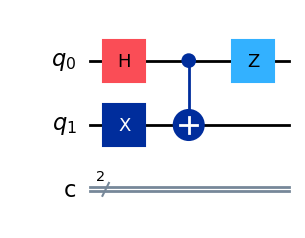

In [2]:
# Étape 1 : créer le circuit qui génère la paire intriquée (|ψ->)
def create_entangled_pair_circuit() -> QuantumCircuit:
    circuit = QuantumCircuit(2, 2)

    circuit.x(1)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.z(0)

    return circuit

# Affichage des résultats
circuit = create_entangled_pair_circuit()
display(circuit.draw('mpl'))

Circuit de mesure 0:


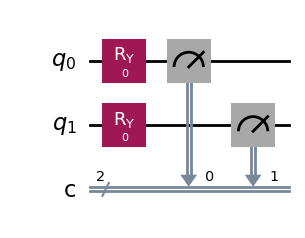

Circuit de mesure 1:


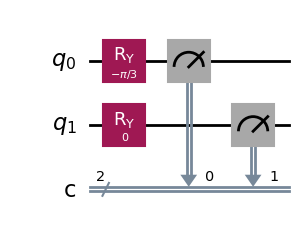

Circuit de mesure 2:


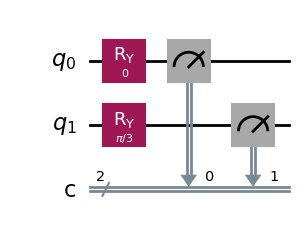

Circuit de mesure 3:


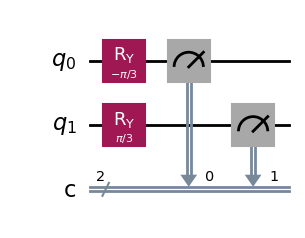

In [3]:
# Étape 2 : créer 4 nouveaux circuits de mesure
def create_measurement_circuit(angle_a_deg: float, angle_b_deg: float) -> QuantumCircuit:
    qc = QuantumCircuit(2, 2)

    theta_a = numpy.deg2rad(2 * angle_a_deg)
    theta_b = numpy.deg2rad(2 * angle_b_deg)

    qc.ry(theta_a, 0)
    qc.ry(theta_b, 1)
    qc.measure(0, 0)
    qc.measure(1, 1)

    return qc

def create_all_measurement_circuits() -> list[QuantumCircuit]:
    return [
        create_measurement_circuit(0, 0),
        create_measurement_circuit(-30, 0),
        create_measurement_circuit(0, 30),
        create_measurement_circuit(-30, 30),
    ]

# Affichage des résultats
circuits = create_all_measurement_circuits()
for i, circuit in enumerate(circuits):
    print(f"Circuit de mesure {i}:")
    display(circuit.draw('mpl'))


In [4]:
# Étape 3 : générer deux chaînes de bits aléatoires de taille 1024
def generate_random_measurement_settings(batch_size: int) -> tuple[list[int], list[int]]:
    rng = numpy.random.default_rng()

    alice_settings = rng.integers(low = 0, high = 2, size = batch_size).tolist()
    bob_settings = rng.integers(low = 0, high = 2, size = batch_size).tolist()

    return alice_settings, bob_settings

def generate_step3_settings() -> tuple[list[int], list[int]]:
    return generate_random_measurement_settings(batch_size = 1024)

# Affichage des résultats
alice, bob = generate_step3_settings()
print("Alice settings (10 premiers):", alice[:10])
print("Bob settings (10 premiers):", bob[:10])

Alice settings (10 premiers): [0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
Bob settings (10 premiers): [0, 1, 0, 0, 0, 0, 0, 0, 1, 1]


In [5]:
# Étape 4 : répéter 1024 fois le processus de mesure avec des circuits choisis aléatoirement
def choose_measurement_circuit_randomly(measurement_circuits: list[QuantumCircuit], rng: numpy.random.Generator) -> QuantumCircuit:
    index = int(rng.integers(low = 0, high = len(measurement_circuits)))
    return measurement_circuits[index]

def compose_and_run_once(sampler: StatevectorSampler, entangling_circuit: QuantumCircuit, measurement_circuit: QuantumCircuit) -> str:
    full_circuit = entangling_circuit.compose(measurement_circuit, inplace=False)
    job = sampler.run([full_circuit], shots = 1)
    result = job.result()

    return result[0].data.c.get_bitstrings()[0]

def run_step4_random_batch(entangling_circuit: QuantumCircuit, measurement_circuits: list[QuantumCircuit], batch_size: int = 1024) -> list[str]:
    rng = numpy.random.default_rng()
    sampler = StatevectorSampler()
    results = []

    for _ in range(batch_size):
        circuit = choose_measurement_circuit_randomly(measurement_circuits, rng)
        bitstring = compose_and_run_once(sampler, entangling_circuit, circuit)
        results.append(bitstring)

    return results

# Affichage des résultats
entangled = create_entangled_pair_circuit()
measurements = create_all_measurement_circuits()
results = run_step4_random_batch(entangled, measurements)
print("First 10 measurement results:", results[:10])

First 10 measurement results: ['11', '00', '10', '01', '10', '01', '11', '10', '01', '10']


In [6]:
# Étape 5 : sauvegarder la clé secrète d'Alice
def extract_alice_bit_from_bitstring(bitstring: str) -> int:
    return int(bitstring[1])

def extract_key_from_results(bitstrings: list[str]) -> list[int]:
    key = []

    for bitstring in bitstrings:
        alice_bit = extract_alice_bit_from_bitstring(bitstring)
        key.append(alice_bit)

    return key

# Affichage des résultats
entangled = create_entangled_pair_circuit()
measurements = create_all_measurement_circuits()
results = run_step4_random_batch(entangled, measurements)
key = extract_key_from_results(results)
print("Key length:", len(key))
print("First 50 key bits:", key[:50])

Key length: 1024
First 50 key bits: [0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1]


In [13]:
# Étape 6 - 7 :
def compute_p00_from_angles(angle_a_deg: float, angle_b_deg: float) -> float:
    qc = QuantumCircuit(2)
    qc.x(1)
    qc.h(0)
    qc.cx(0, 1)
    qc.z(0)

    theta_a = numpy.deg2rad(2 * angle_a_deg)
    theta_b = numpy.deg2rad(2 * angle_b_deg)
    qc.ry(theta_a, 0)
    qc.ry(theta_b, 1)

    state = Statevector.from_instruction(qc)
    p00 = float(numpy.abs(state.data[0]) ** 2)
    return p00

def run_step_6_7_batch() -> list[int]:
    p_minus30_0 = compute_p00_from_angles(-30.0, 0.0)
    p_0_30 = compute_p00_from_angles(0.0, 30.0)
    p_minus30_30 = compute_p00_from_angles(-30.0, 30.0)

    print(f"(-30°, 0°): {p_minus30_0:6f}")
    print(f"(0°, 30°): {p_0_30:6f}")
    print(f"(-30°, 30°): {p_minus30_30:6f}")

    W = p_minus30_0 + p_0_30 - p_minus30_30
    return W

run_step_6_7_batch()

(-30°, 0°): 0.125000
(0°, 30°): 0.125000
(-30°, 30°): 0.375000


-0.12500000000000006